In [1]:
import sys
import torch
import torchvision

# check environment
print("Python version: ", sys.version)
print("Pytorch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)

!nvidia-smi

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version:  3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
Pytorch version:  1.13.0a0+d0d6b1f
Torchvision version:  0.14.0a0
Wed Nov  2 02:40:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:34:00.0 Off |                    0 |
| N/A   37C    P0    93W / 350W |   2385MiB / 32510MiB |     80%      Default |
|                               |                      |                  N/A |
+--

https://www.kaggle.com/code/abhiswain/pytorch-mnist-using-pretrained-resnet50

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
# import seaborn as sns 
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""
    
    def __init__(self, file_path, 
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        
        df = pd.read_csv(file_path)
        
        if len(df.columns) == 784:
            # test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [4]:
batch_size = 64

train_dataset = MNIST_data('/mnt/data/pa_finance/clip/train.csv', transform= transforms.Compose(
                            [transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_dataset = MNIST_data('/mnt/data/pa_finance/clip/test.csv')

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

In [5]:
model = models.resnet50(pretrained=True)

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def change_layers(model):
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(2048, 10, bias=True)
    return model

In [7]:
change_layers(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
if(torch.cuda.is_available()):
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
import time

print('Training....')
total = 0
correct = 0
start = time.time()

for epoch in range(1):
    
    for i, data in enumerate(train_loader, 1):
        images, labels = data

        if(torch.cuda.is_available()):
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()    
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        if(i%100 == 0):
            print('Epoch: {} Batch: {} loss: {}'.format(epoch, i, loss.item()))

        loss.backward()
        optimizer.step()

print('Training Completed in: {} secs'.format(time.time()-start))
print('Training accuracy: {} %'.format((correct/total)*100))


Training....
Epoch: 0 Batch: 100 loss: 0.42270636558532715
Epoch: 0 Batch: 200 loss: 0.2889871299266815
Epoch: 0 Batch: 300 loss: 0.3024958074092865
Epoch: 0 Batch: 400 loss: 0.08971835672855377
Epoch: 0 Batch: 500 loss: 0.1581156998872757
Epoch: 0 Batch: 600 loss: 0.12862199544906616
Training Completed in: 21.256571292877197 secs
Training accuracy: 88.71190476190476 %


In [10]:
predicted

tensor([3, 4, 4, 1, 8, 2, 0, 7, 8, 7, 8, 3, 9, 2, 9, 6], device='cuda:0')

In [11]:
torch.max(outputs.data,1)

torch.return_types.max(
values=tensor([ 7.5084,  7.9004,  8.1034, 12.4506,  7.6401,  6.6723, 10.6654,  7.3402,
         5.6336,  8.8130,  5.9158,  7.3375,  2.3313,  7.8869, 10.3269,  4.8685],
       device='cuda:0'),
indices=tensor([3, 4, 4, 1, 8, 2, 0, 7, 8, 7, 8, 3, 9, 2, 9, 6], device='cuda:0'))

In [12]:
criterion = nn.CrossEntropyLoss()
criterion(outputs, labels)

tensor(0.1542, device='cuda:0', grad_fn=<NllLossBackward0>)

In [14]:
print('Predicting....')
start = time.time()

predictions = torch.LongTensor()
for i, data in enumerate(test_loader, 1):
    data = data.cuda()
    
    if(i%100 == 0):
        print('Batch {} done'.format(i))
    outputs = model(data)
    
    pred = outputs.cpu().data.max(1, keepdim=True)[1]
    predictions = torch.cat((predictions, pred), dim=0)
    
print('Completed in {} secs'.format(time.time() - start))

Predicting....
Batch 100 done
Batch 200 done
Batch 300 done
Batch 400 done
Completed in 8.588757991790771 secs


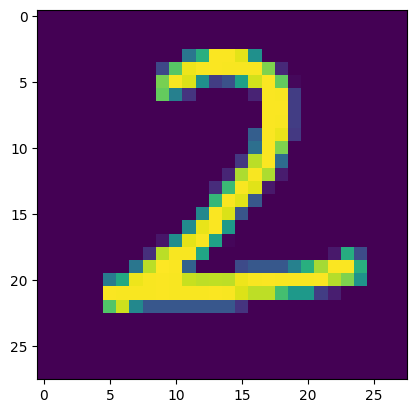

In [26]:
test_idx = 13
plt.imshow(images[test_idx].cpu().numpy().reshape(28,28))
plt.show()

In [27]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], predictions.numpy()], columns=['ImageId', 'Label'])
#out_df.to_csv('submission.csv', index=False)

In [28]:
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
